Imports:

In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import torch
import utils
import math
import matplotlib.pyplot as plt

Helper function for displaying generated images:

In [2]:
def display(x):
    if isinstance(x, torch.Tensor):
        x = x.detach().cpu()
        if x.dim() == 3 and x.shape[0] == 1:
            x = x.squeeze(0)
        elif x.dim() == 4 and x.shape[1] == 1:
            x = x[0, 0]
        x = (x + 3) / 6.0
        x = torch.clamp(x, 0, 1)
        plt.imshow(x.numpy(), cmap="gray")
        plt.axis('off')
        plt.show()
    else:
        raise TypeError("Input must be a torch.Tensor")

Convolutional Layer (with time affine time encoding):

In [3]:
class ConvolutionalBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, time_encoding_dim = 16):
        super(ConvolutionalBlock, self).__init__()

        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size = 4, stride = 2, padding = 1)

        self.gn = torch.nn.GroupNorm(1, out_channels)
        self.time_scale = torch.nn.Linear(time_encoding_dim, out_channels)
        self.time_shift = torch.nn.Linear(time_encoding_dim, out_channels)

        self.activation = torch.nn.SiLU()

    def forward(self, x, time_encoding):
        time_scale = self.time_scale(time_encoding).unsqueeze(-1).unsqueeze(-1)
        time_shift = self.time_shift(time_encoding).unsqueeze(-1).unsqueeze(-1)

        time_scale = self.activation(time_scale)
        time_shift = self.activation(time_shift)


        
        x = self.conv(x)
        
        x = self.activation(x)
        x = self.gn(x)

        x = x * time_scale + time_shift # affine time encoding

        return x

Deconvolution (Transposed Convolution) with affine time encoding and skip connection:

In [4]:
class ConvolutionalBlockTranspose(torch.nn.Module):
    def __init__(self, in_channels, out_channels, time_encoding_dim = 16, skip_connection_channels = 0):
        super(ConvolutionalBlockTranspose, self).__init__()
        self.conv = torch.nn.ConvTranspose2d(
            in_channels + skip_connection_channels, 
            out_channels, 
            kernel_size = 4,
            stride = 2, 
            padding = 1
        )

        self.gn = torch.nn.GroupNorm(1, out_channels)
        self.time_scale = torch.nn.Linear(time_encoding_dim, out_channels)
        self.time_shift = torch.nn.Linear(time_encoding_dim, out_channels)

        self.activation = torch.nn.SiLU()

    def forward(self, x, time_encoding, skip_connection):

        time_scale = self.time_scale(time_encoding).unsqueeze(-1).unsqueeze(-1)
        time_shift = self.time_shift(time_encoding).unsqueeze(-1).unsqueeze(-1)

        time_scale = self.activation(time_scale)
        time_shift = self.activation(time_shift)

        x = torch.cat([x, skip_connection], dim = 1)

        
        x = self.conv(x)
        x = self.activation(x)
        x = self.gn(x)

        x = x * time_scale + time_shift # affine time encoding

        return x
    


U-Net architecture:

In [25]:
class MNISTUnet(torch.nn.Module):
    def __init__(self, latent_dim, time_encoding_dim = 16):
        super(MNISTUnet, self).__init__()
        
        self.encoder_conv = torch.nn.ModuleList([
            ConvolutionalBlock(1, 32, time_encoding_dim),
            ConvolutionalBlock(32, 64, time_encoding_dim),
        ])

        self.dense = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.SiLU(),
            torch.nn.Linear(64 * 7 * 7, latent_dim),
            torch.nn.SiLU(),
            torch.nn.Linear(latent_dim, 64 * 7 * 7),
            torch.nn.SiLU(),
            torch.nn.Unflatten(1, (64, 7, 7))
        )


        self.decoder_conv = torch.nn.ModuleList([
            ConvolutionalBlockTranspose(64, 32, time_encoding_dim, skip_connection_channels = 64),
            ConvolutionalBlockTranspose(32, 1, time_encoding_dim, skip_connection_channels = 32)

        ])

        self.latent_dim = latent_dim
        self.time_encoding_dim = time_encoding_dim

        self.time_mlp = torch.nn.Sequential(
            torch.nn.Linear(time_encoding_dim, time_encoding_dim * 4),
            torch.nn.SiLU(),
            torch.nn.Linear(time_encoding_dim * 4, time_encoding_dim),
            torch.nn.SiLU(),
        )

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def time_encoding(self, t):
        sin = torch.cat([torch.sin(2 * math.pi * t * mul / self.steps).unsqueeze(1) for mul in range(1, self.time_encoding_dim // 2 + 1)], dim = 1)
        cos = torch.cat([torch.cos(2 * math.pi * t * mul / self.steps).unsqueeze(1) for mul in range(1, self.time_encoding_dim // 2 + 1)], dim = 1)
        
        out = torch.cat([sin, cos], dim = 1)
        return out
    
    def forward(self, x, t):
        time_encoding = self.time_encoding(t)
        time_encoding = self.time_mlp(time_encoding)

        skip_connections = []
        for idx, conv in enumerate(self.encoder_conv):
            x = conv(x, time_encoding)
            skip_connections.append(x.clone())

        x = self.dense(x)

        for idx, conv in enumerate(self.decoder_conv):
            x = conv(x, time_encoding, skip_connections[-(idx + 1)])

        return x

In [26]:
class MNISTDiffusionModel(MNISTUnet):
    def __init__(self, latent_dim = 2, time_encoding_dim = 2, beta_min = 0.001, beta_max = 0.02, steps = 1000):
        super(MNISTDiffusionModel, self).__init__(latent_dim = latent_dim, time_encoding_dim = time_encoding_dim)

        self.steps = steps

        self.beta = torch.linspace(beta_min, beta_max, steps)
        self.alpha = 1 - self.beta

        self.alpha_hat = torch.cumprod(self.alpha, dim = 0)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)

        self.loss_fn = torch.nn.MSELoss(reduction="mean")

        self.beta = self.beta.to(self.device)
        self.alpha_hat = self.alpha_hat.to(self.device)
        self.alpha = self.alpha.to(self.device)

        self.reconstructing_noise = False


    def train_step(self, x, t = None):
        x = x.to(self.device)
        if t is None:
            t = torch.randint(0, len(self.alpha) - 1, (x.size(0),)).long()
        noise = torch.randn_like(x).to(self.device)
        t = t.to(self.device)
        x_t = torch.sqrt(self.alpha_hat[t].reshape(-1, 1, 1, 1)) * x + torch.sqrt(1 - self.alpha_hat[t].reshape(-1, 1, 1, 1)) * noise
        output = self(x_t, t)
        if self.reconstructing_noise:
            loss = self.loss_fn(output, noise)
        else:
            loss = self.loss_fn(output, x)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()


    def sample(self, x = None, T = None):
        if x is None:
            x = torch.randn((1, 1, 28, 28)).to(self.device)
        if T is None:
            T = self.steps - 1
        for t in tqdm(range(T - 1, 0, -1)):
            t = torch.tensor([t]).to(self.device)
            if self.reconstructing_noise:
                recon_noise = self(x, t)
            else:
                recon_x = self(x, t)
                recon_noise  = x - recon_x
            mu = 1 / torch.sqrt(self.alpha[t]) * (x - (1 - self.alpha[t]) / torch.sqrt(1 - self.alpha_hat[t] + 1e-5) * recon_noise)
            sigma = torch.sqrt(self.beta[t])
            x = mu + sigma * torch.randn_like(x)
        if self.reconstructing_noise:
            recon_noise = self(x, torch.tensor([0]).to(self.device)).to(self.device)
        else:
            recon_x = self(x, torch.tensor([0]).to(self.device)).to(self.device)
            recon_noise  = x - recon_x
        x = 1 / torch.sqrt(self.alpha[0]) * (x - (1 - self.alpha[0]) / torch.sqrt(1 - self.alpha_hat[0] + 1e-5) * recon_noise)
        return x

In [41]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
])
    
    
train_dataset = datasets.MNIST(root='./data', train = True, download = True, transform = transform)

In [42]:
indices = [i for i, (_, label) in enumerate(train_dataset) if label == 7]
train_dataset = Subset(train_dataset, indices)

In [43]:
epochs = 10

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
model = MNISTDiffusionModel(latent_dim = 16, time_encoding_dim = 16, steps = 1000)
for epoch in range(epochs):
    model.train()
    loss = 0
    for x, _ in tqdm(train_loader):
        loss += model.train_step(x)
    print(f"Epoch {epoch + 1}, Loss: {loss}")

100%|██████████| 98/98 [00:02<00:00, 46.98it/s]


Epoch 1, Loss: 48.232021510601044


100%|██████████| 98/98 [00:02<00:00, 47.04it/s]


Epoch 2, Loss: 30.778204411268234


100%|██████████| 98/98 [00:02<00:00, 46.68it/s]


Epoch 3, Loss: 29.146579816937447


100%|██████████| 98/98 [00:02<00:00, 46.83it/s]


Epoch 4, Loss: 29.02911476790905


100%|██████████| 98/98 [00:02<00:00, 46.70it/s]


Epoch 5, Loss: 29.125365898013115


100%|██████████| 98/98 [00:02<00:00, 46.98it/s]


Epoch 6, Loss: 28.69750612974167


100%|██████████| 98/98 [00:02<00:00, 46.72it/s]


Epoch 7, Loss: 27.923026248812675


100%|██████████| 98/98 [00:02<00:00, 46.89it/s]


Epoch 8, Loss: 27.820910692214966


100%|██████████| 98/98 [00:02<00:00, 46.92it/s]


Epoch 9, Loss: 27.723757222294807


100%|██████████| 98/98 [00:02<00:00, 46.33it/s]

Epoch 10, Loss: 27.38690534234047


100%|██████████| 998/998 [00:03<00:00, 300.95it/s]


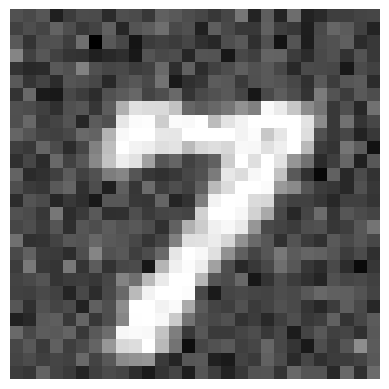

In [44]:
model.eval()
with torch.no_grad():
    recon = model.sample()
    utils.display(recon)